In [1]:
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as crs
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 
import cartopy

In [37]:
matplotlib.rcParams.update({'font.size': 20})

In [31]:
sla = xr.open_dataset("./Satellite_Data_SAC/sla_BOB_2018.nc")

We find below that the data is absolute dynamic ocean topography and not the sea level anomaly

$\Large SLA = ADT - \overline{ADT}$

Where, SLA is the sea level anomaly, ADT is the absolute dynamic topography, and $\overline{ADT}$ is the time mean

In [4]:
sla

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 88, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * longitude  (longitude) float32 78.125 78.375 78.625 ... 99.375 99.625 99.875
  * latitude   (latitude) float32 5.125 5.375 5.625 ... 24.375 24.625 24.875
Data variables:
    adt        (time, latitude, longitude) float64 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.4 (ht...
    Conventions:                     CF-1.6
    history:                         Fri Feb 15 15:49:27 2019: cdo sellonlatb...
    source:                          Altimetry measurements
    institution:                     CLS, CNES
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:    

We compute the sea level anomaly as below:

In [32]:
sla_anom = sla.adt - sla.adt.mean(dim='time')

/home/aditya/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


We shall change the name of the data variable sla_anom as "SLA (m)", otherwise, it simply copies the name from the ADT variable

In [33]:
sla_anom.name = "SLA(m)"

We need a high resolution land mask which will resolve the Andaman islands as well, so let's make use of Cartopy's feature and download a 50m resolution land mask. We'll give it a facecolor of black

In [4]:
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor= 'k')

Let's plot an example plot at the first time step before looping over each time step and plotting frames to produce an animated figure

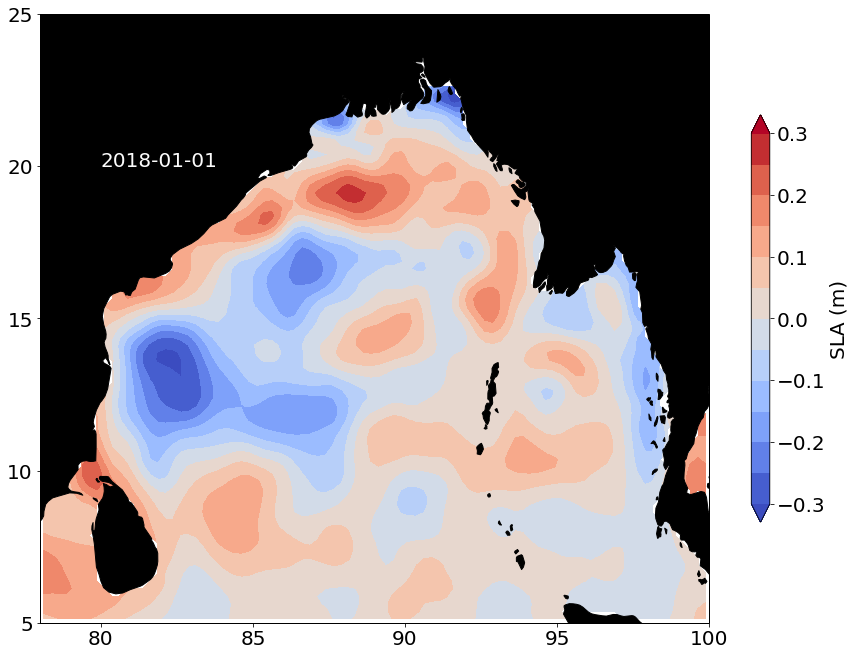

In [10]:
plt.close(1)
plt.figure(1, figsize=(15, 15))
ax = plt.subplot(projection=crs.PlateCarree())
#ax.coastlines()
t = sla_anom.time[0]
Q = plt.contourf(sla_anom.longitude, sla_anom.latitude, sla_anom.isel(time=0), vmin=-0.3, vmax=0.3, 
                 levels=np.arange(-0.3, 0.31, 0.05), extend='both', cmap='coolwarm')
ax.set_extent([78, 100, 5, 25])
ax.set_xticks(np.arange(80, 101, 5) )
ax.set_yticks(np.arange(5, 26, 5) )

ax.add_feature(land_50m)
plt.text(80,20, str.split(str(t.values), 'T')[0], color='0.99')
#longrid, latgrid = np.meshgrid(bathyS.lon.values, bathyS.lat.values)
#ax.contourf(longrid, latgrid, bathyS.elevation.where(bathyS.elevation > 0).values, cmap='Greens' )

plt.colorbar(Q, ax=ax, shrink=0.5, label="SLA (m)")
plt.show()

Next, we need to find the indices at the time step which fall within our period of 1st April to 31st October

In [12]:
np.where(sla_anom.time == np.datetime64("2018-04-01") )

(array([90]),)

In [11]:
np.where(sla_anom.time == np.datetime64("2018-10-31") )

(array([303]),)

In [16]:
!rm ./animations/sla/*.png

Let's loop over between the above indices at a daily interval

/home/aditya/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


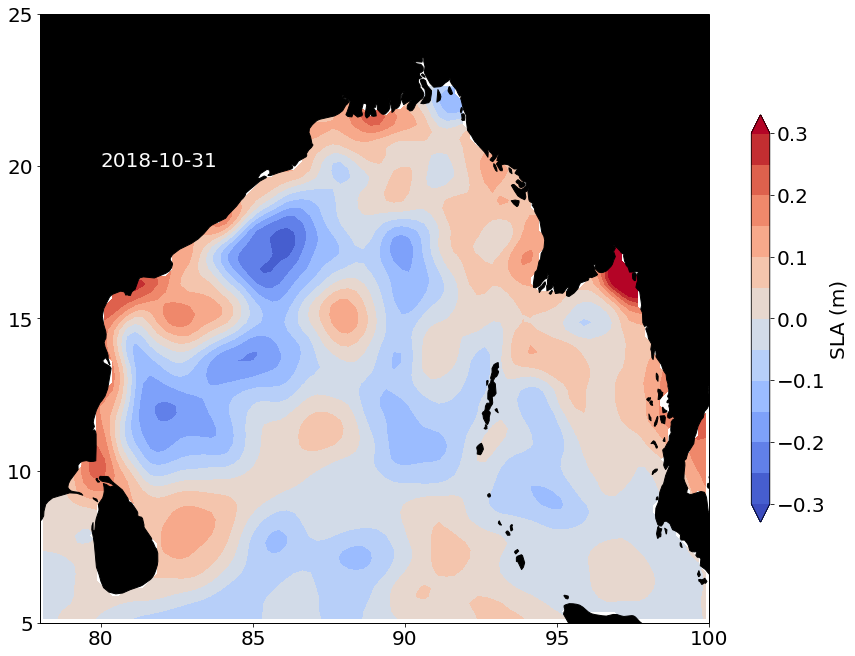

In [18]:
for tind in range(90, 304, 1):
    t = sla_anom.time[tind]
    plt.close(1)
    plt.figure(1, figsize=(15, 15))
    ax = plt.subplot(projection=crs.PlateCarree())
    #ax.coastlines()

    CF = plt.contourf(sla_anom.longitude, sla_anom.latitude, sla_anom.sel(time=t), vmin=-0.3, vmax=0.3, 
                 levels=np.arange(-0.3, 0.31, 0.05), extend='both', cmap='coolwarm')
    ax.set_extent([78, 100, 5, 25])
    ax.set_xticks(np.arange(80, 101, 5) )
    ax.set_yticks(np.arange(5, 26, 5) )

    ax.add_feature(land_50m)
    plt.text(80,20, str.split(str(t.values), 'T')[0], color='0.99')

    plt.colorbar(CF, ax=ax, shrink=0.5, label="SLA (m)")
    plt.tight_layout()
    #plt.title(str.split(str(t.values), 'T')[0])
    plt.savefig("./animations/sla/"+str.split(str(t.values), 'T')[0]+".png" )

Next, we use any tool to stitch together the frames produced to make an animation. If you have a Linux system, you can install imagemagik and run the following script

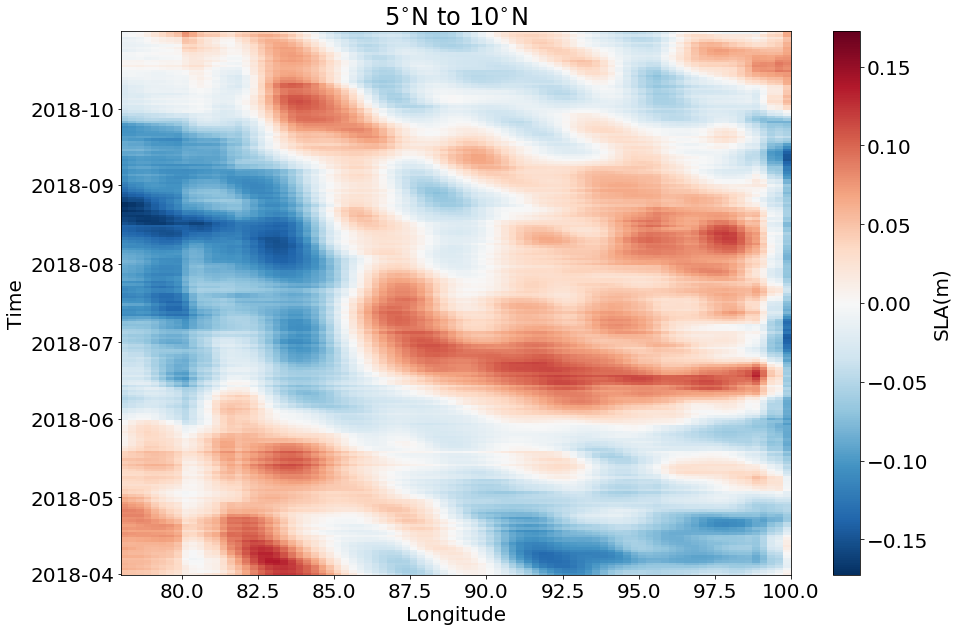

In [9]:
plt.figure(figsize=(15,10))
#ax = plt.subplot(projection = crs.PlateCarree())
sla_anom_plt = sla_anom.sel(latitude=slice(5, 10), time=slice("2018-04-01", "2018-10-31")).mean(dim="latitude").plot()
#plt.colorbar(sla_anom_plt)
plt.title("$5^{\circ}$N to $10^{\circ}$N")
plt.xlabel("Longitude")
plt.savefig("./plots/sla_lon_time_hovmoller.png")

/home/aditya/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


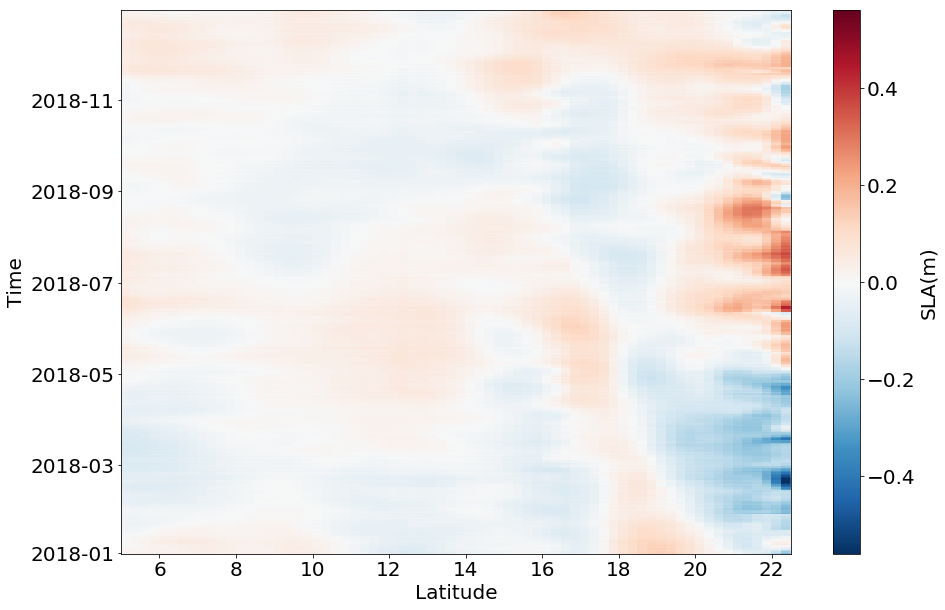

In [42]:
plt.figure(figsize=(15,10))
#ax = plt.subplot(projection = crs.PlateCarree())
sla_anom_plt = sla_anom.sel(longitude=slice(78, 100), time=slice("2018-01-01", "2018-12-31")).mean(dim="longitude").plot()
#plt.colorbar(sla_anom_plt)
plt.xlabel("Latitude")
#plt.title("$78^{\circ}$E to $89^{\circ}$E")
plt.xlim(5, 22.5)
plt.savefig("./plots/sla_lat_time_hovmoller.png")

## Whole Bay : 78E to 100E; 5N to 25N
## North Bay: 78E to 100E; 16N to 25N
## SW Bay: 78E to 89E; 5N to 16N
## SE Bay: 89E to 100E; 5N to 16N

In [8]:
!mkdir ./plots/sla

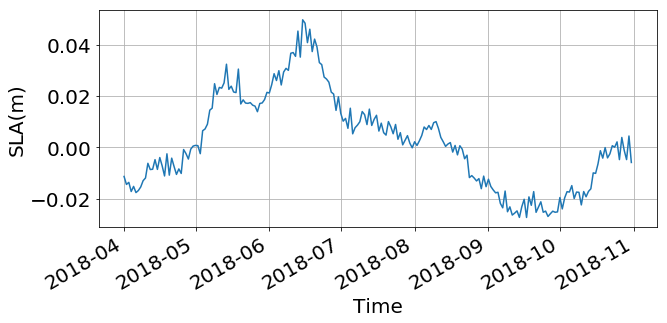

In [40]:
plt.figure(figsize=(10,4))
sla_anom.sel(longitude=slice(78, 100), latitude=slice(5, 25), time=slice("2018-04-01", "2018-10-31")).\
mean(dim=['longitude', 'latitude']).plot(label="Whole Bay")
plt.grid()
plt.savefig("./plots/sla/time_series_whole_bay.png", bbox_inches="tight")

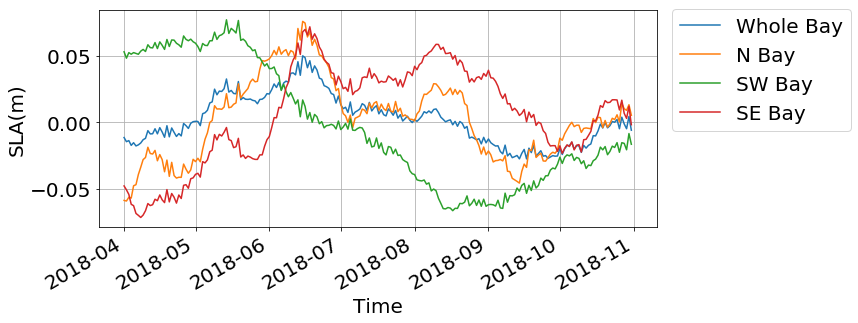

In [10]:
plt.figure(figsize=(10, 4))
sla_anom.sel(longitude=slice(78, 100), latitude=slice(5, 25), time=slice("2018-04-01", "2018-10-31")).\
mean(dim=['longitude', 'latitude']).plot(label="Whole Bay")

sla_anom.sel(longitude=slice(78, 100), latitude=slice(16, 25), time=slice("2018-04-01", "2018-10-31")).\
mean(dim=['longitude', 'latitude']).plot(label="N Bay")

sla_anom.sel(longitude=slice(78, 89), latitude=slice(5, 16), time=slice("2018-04-01", "2018-10-31")).\
mean(dim=['longitude', 'latitude']).plot(label="SW Bay")

sla_anom.sel(longitude=slice(89, 100), latitude=slice(5, 16), time=slice("2018-04-01", "2018-10-31")).\
mean(dim=['longitude', 'latitude']).plot(label="SE Bay")

plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.grid()
plt.savefig("./plots/sla/sla_boxes.png", dpi=300, bbox_inches="tight")

In [5]:
duacs = xr.open_dataset("./Satellite_Data_SAC/dataset-duacs-nrt-global-merged-allsat-phy-l4_1549625798751.nc")

In [9]:
duacs

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 321, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float32 -29.875 -29.625 -29.375 ... 29.875 30.125
  * longitude  (longitude) float32 40.125 40.375 40.625 ... 119.875 120.125
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    err        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         s

In [24]:
duacs.ugos

<xarray.DataArray 'ugos' (time: 365, latitude: 241, longitude: 321)>
[28236765 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float32 -29.875 -29.625 -29.375 ... 29.875 30.125
  * longitude  (longitude) float32 40.125 40.375 40.625 ... 119.875 120.125
Attributes:
    grid_mapping:   crs
    long_name:      Absolute geostrophic velocity: zonal component
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    units:          m/s

In [28]:
duacs.isel(time=0).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 321)
Coordinates:
    time       datetime64[ns] 2018-01-01
  * latitude   (latitude) float32 -29.875 -29.625 -29.375 ... 29.875 30.125
  * longitude  (longitude) float32 40.125 40.375 40.625 ... 119.875 120.125
Data variables:
    adt        (latitude, longitude) float64 ...
    ugos       (latitude, longitude) float64 ...
    vgos       (latitude, longitude) float64 ...
    vgosa      (latitude, longitude) float64 ...
    err        (latitude, longitude) float64 ...
    sla        (latitude, longitude) float64 ...
    ugosa      (latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email: 

NameError: name 'sla_anom' is not defined

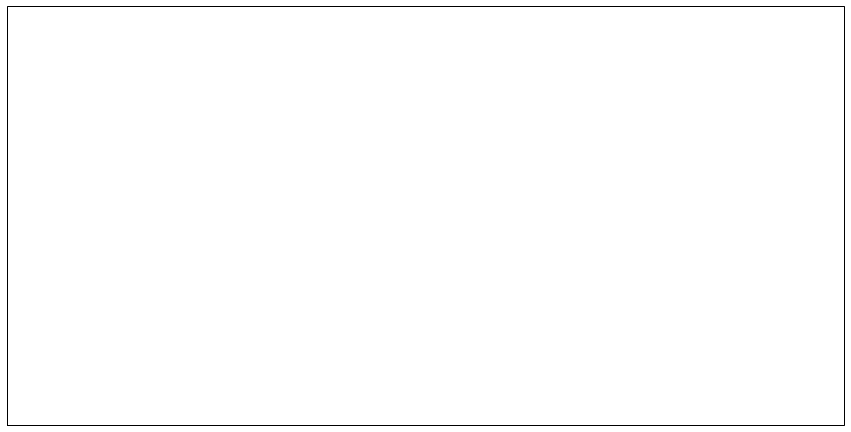

In [113]:
plt.close(1)
plt.figure(1, figsize=(15, 15))
ax = plt.subplot(projection=crs.PlateCarree())
#ax.coastlines()
t = sla_anom.time[0]
Q = plt.contourf(sla_anom.longitude, sla_anom.latitude, sla_anom.isel(time=0), vmin=-0.3, vmax=0.3, 
                 levels=np.arange(-0.3, 0.31, 0.05), extend='both', cmap='coolwarm')
ax.set_extent([78, 100, 5, 25])
ax.set_xticks(np.arange(80, 101, 5) )
ax.set_yticks(np.arange(5, 26, 5) )

ax.add_feature(land_50m)

skip = 2
geos_quiver = ax.quiver(duacs.longitude[::skip], duacs.latitude[::skip], duacs.ugos.isel(time=0).values[::skip, ::skip], 
                        duacs.vgos.isel(time=0).values[::skip, ::skip], scale=10)


ax.quiverkey(geos_quiver, 0.8, 0.9, 0.5, '0.5 ms$^{-1}$', labelpos='E', color='1.0', labelcolor='1.0')

plt.text(80,20, str.split(str(t.values), 'T')[0], color='0.99')
#longrid, latgrid = np.meshgrid(bathyS.lon.values, bathyS.lat.values)
#ax.contourf(longrid, latgrid, bathyS.elevation.where(bathyS.elevation > 0).values, cmap='Greens' )

plt.colorbar(Q, ax=ax, shrink=0.5, label="SLA (m)")
plt.show()

In [1]:
!rm ./animations/sla_geos/*.png

In [ ]:
for tind in range(90, 304, 2):
    t = sla_anom.time[tind]
    plt.close(1)
    plt.figure(1, figsize=(15, 15))
    ax = plt.subplot(projection=crs.PlateCarree())
    #ax.coastlines()

    CF = plt.contourf(sla_anom.longitude, sla_anom.latitude, sla_anom.sel(time=t), vmin=-0.3, vmax=0.3, 
                 levels=np.arange(-0.3, 0.31, 0.05), extend='both', cmap='coolwarm')
    ax.set_extent([78, 100, 5, 25])
    ax.set_xticks(np.arange(80, 101, 5) )
    ax.set_yticks(np.arange(5, 26, 5) )

    ax.add_feature(land_50m)
    plt.text(80,20, str.split(str(t.values), 'T')[0], color='0.99')

    skip = 2
    geos_quiver = ax.quiver(duacs.longitude[::skip], duacs.latitude[::skip], 
                            duacs.ugos.isel(time=tind).values[::skip, ::skip], 
                            duacs.vgos.isel(time=tind).values[::skip, ::skip], scale=10)
    
    ax.quiverkey(geos_quiver, 0.8, 0.9, 0.5, '0.5 ms$^{-1}$', labelpos='E', color='1.0', labelcolor='1.0')

    plt.colorbar(CF, ax=ax, shrink=0.5, label="SLA (m)")
    #plt.tight_layout()
    #plt.title(str.split(str(t.values), 'T')[0])
    plt.savefig("./animations/sla_geos/"+str.split(str(t.values), 'T')[0]+".png", bbox_inches='tight' )

## How do the geostrophic and ageostrophic currents compare across the seasons as the wind magnitudes pick up and drop off?

Let's read the total current data, and subtract the geostrophic velocity components from them

$\large \text{u}_{\text{Total}} = \text{u}_{\text{geos}} + \text{u}_{\text{ageos}}$

In [6]:
curr = xr.open_dataset("./Satellite_Data_SAC/ISRO_CURRENT_BOB_2018.nc")

In [20]:
curr

<xarray.Dataset>
Dimensions:    (Depth: 1, Latitude: 81, Longitude: 89, Time: 346)
Coordinates:
  * Time       (Time) datetime64[ns] 2017-12-30 2017-12-31 ... 2018-12-27
  * Longitude  (Longitude) float32 78.0 78.25 78.5 78.75 ... 99.5 99.75 100.0
  * Latitude   (Latitude) float32 5.0 5.25 5.5 5.75 ... 24.25 24.5 24.75 25.0
  * Depth      (Depth) float64 15.0
Data variables:
    U          (Time, Depth, Latitude, Longitude) float32 ...
    V          (Time, Depth, Latitude, Longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.4 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    history:      Fri Feb 15 15:46:05 2019: cdo sellonlatbox,78,100,5,25 ISRO...
    CDO:          Climate Data Operators version 1.9.4 (http://mpimet.mpg.de/...

In [26]:
curr.Longitude[0]

<xarray.DataArray 'Longitude' ()>
array(78., dtype=float32)
Coordinates:
    Longitude  float32 78.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [29]:
np.argmin(np.abs(duacs.longitude - 78))

<xarray.DataArray 'longitude' ()>
array(151)

In [8]:
duacs.longitude[151]

<xarray.DataArray 'longitude' ()>
array(77.875, dtype=float32)
Coordinates:
    longitude  float32 77.875
Attributes:
    axis:                 X
    bounds:               lon_bnds
    long_name:            Longitude
    standard_name:        longitude
    units:                degrees_east
    valid_max:            359.875
    valid_min:            0.125
    _CoordinateAxisType:  Lon

In [32]:
np.argmin(np.abs(duacs.longitude - 100))

<xarray.DataArray 'longitude' ()>
array(239)

In [33]:
np.argmin(np.abs(duacs.latitude - 5))

<xarray.DataArray 'latitude' ()>
array(139)

In [34]:
np.argmin(np.abs(duacs.latitude - 25))

<xarray.DataArray 'latitude' ()>
array(219)

In [35]:
np.where(duacs.time == np.datetime64("2018-12-27") )

(array([360]),)

In [7]:
duacs_interpolated = duacs.interp(longitude=curr.Longitude, latitude=curr.Latitude)

In [28]:
duacs_interpolated

<xarray.Dataset>
Dimensions:    (Latitude: 81, Longitude: 89, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
    longitude  (Longitude) float32 78.0 78.25 78.5 78.75 ... 99.5 99.75 100.0
    latitude   (Latitude) float32 5.0 5.25 5.5 5.75 ... 24.25 24.5 24.75 25.0
  * Longitude  (Longitude) float32 78.0 78.25 78.5 78.75 ... 99.5 99.75 100.0
  * Latitude   (Latitude) float32 5.0 5.25 5.5 5.75 ... 24.25 24.5 24.75 25.0
Data variables:
    adt        (time, Latitude, Longitude) float64 0.9187 0.9246 ... nan nan
    ugos       (time, Latitude, Longitude) float64 -0.6277 -0.6447 ... nan nan
    vgos       (time, Latitude, Longitude) float64 0.1428 0.1595 ... nan nan
    vgosa      (time, Latitude, Longitude) float64 0.1302 0.1438 ... nan nan
    err        (time, Latitude, Longitude) float64 0.01327 0.01285 ... nan nan
    sla        (time, Latitude, Longitude) float64 0.1348 0.1401 ... nan nan
    ugosa      (time, Latitude, Longitude) flo

### We have aligned the lat lon coordinates of duacs with that of the current data, but take care regarding the time axis, which begins and ends on different days for each dataset

For our current plots, we don't need to worry about that for now, because both datasets have data between 1st April and 31st October

In [8]:
u_ag = curr.U.sel(Time=slice("2018-04-01", "2018-10-31"), Depth=15 ) - duacs_interpolated.ugos.sel(time=
                                                                    slice("2018-04-01", "2018-10-31"))

In [9]:
v_ag = curr.V.sel(Time=slice("2018-04-01", "2018-10-31"), Depth=15 ) - duacs_interpolated.vgos.sel(time=
                                                                    slice("2018-04-01", "2018-10-31"))

In [43]:
u_ag.sel(time="2018-04-01", Time="2018-04-01").shape

(81, 89)

In [38]:
u_ag.sel(Time="2018-04-01")

<xarray.DataArray (Latitude: 81, Longitude: 89, time: 214)>
array([[[ 0.323075,  0.3805  , ...,  0.157125,  0.157475],
        [ 0.302975,  0.368225, ...,  0.081575,  0.0923  ],
        ...,
        [-0.0532  , -0.07995 , ..., -0.04015 , -0.026525],
        [-0.0495  , -0.075575, ..., -0.066625, -0.0245  ]],

       [[ 0.3014  ,  0.3535  , ...,  0.175525,  0.142925],
        [ 0.3023  ,  0.358325, ...,  0.1048  ,  0.0813  ],
        ...,
        [-0.082875, -0.046   , ..., -0.058825, -0.0242  ],
        [-0.088225, -0.046325, ..., -0.0372  ,  0.018225]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       n

In [28]:
u_ag

<xarray.DataArray (Time: 203, Latitude: 81, Longitude: 89, time: 214)>
array([[[[ 0.323075, ...,  0.157475],
         ...,
         [-0.0495  , ..., -0.0245  ]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]],


       ...,


       [[[ 0.435075, ...,  0.269475],
         ...,
         [-0.0105  , ...,  0.0145  ]],

        ...,

        [[      nan, ...,       nan],
         ...,
         [      nan, ...,       nan]]]])
Coordinates:
  * Time       (Time) datetime64[ns] 2018-04-01 2018-04-02 ... 2018-10-31
  * Longitude  (Longitude) float32 78.0 78.25 78.5 78.75 ... 99.5 99.75 100.0
  * Latitude   (Latitude) float32 5.0 5.25 5.5 5.75 ... 24.25 24.5 24.75 25.0
    Depth      float64 15.0
  * time       (time) datetime64[ns] 2018-04-01 2018-04-02 ... 2018-10-31
    longitude  (Longitude) float32 78.0 78.25 78.5 78.75 ... 99.5 99.75 100.0
    latitude   (Latitude) float32 5.0 5.25 5.5 5.75 ... 24.25 24.5 24.75 25.0

In [10]:
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor= 'k')

In [37]:
u_ag.sel(time="2018-04-01", Time="2018-04-01").shape

(81, 89)

In [39]:
u_ag.Longitude[::3].shape

(30,)

In [23]:
def plot_geo_ageo_total_currents(time1="2018-04-01", time2=None, save=False, savename="untitled.png"):
    matplotlib.rcParams.update({'font.size': 12})
    plt.close(1)
    plt.figure(1, figsize=(12, 5))
    #gs = gridspec.GridSpec(2, 4, width_ratios=[1,1,1, 0.1] )
    gs = gridspec.GridSpec(4, 4, width_ratios=[1,1,1, 0.05], wspace=0.02, hspace=0 )
    
    skip = 2
    headwidth = 7
    
    ax_total = plt.subplot(gs[:,0], projection= crs.PlateCarree() )
    mag_uv = np.sqrt(curr.U.sel(Time=time1, Depth=15)**2 + curr.V.sel(Time=time1, Depth=15)**2 )
    Q_tot = plt.quiver(curr.Longitude[::skip], curr.Latitude[::skip], curr.U.sel(Time=time1, Depth=15).values[::skip, ::skip], 
                       curr.V.sel(Time=time1, Depth=15).values[::skip, ::skip], mag_uv[::skip, ::skip], 
                       scale=15, clim=(0,1.6), headwidth=headwidth)
    
    ax_total.set_extent([78, 100, 5, 25])
    ax_total.set_xticks(np.arange(80, 100, 5) )
    ax_total.set_yticks(np.arange(5, 26, 5) )
    ax_total.quiverkey(Q_tot, 0.75, 0.9, 1, '1 ms$^{-1}$', labelpos='E', color='1.0', labelcolor='1.0')
    ax_total.add_feature(land_50m)
    ax_total.set_title("Total Currents")
    ax_total.text(79, 23, time1, color="1")
    
    ax_geos = plt.subplot(gs[:,1], projection= crs.PlateCarree() )
    mag_geos = np.sqrt(duacs_interpolated.ugos.sel(time=time1)**2 + duacs_interpolated.vgos.sel(time=time1)**2 )
    Q_geos = plt.quiver(curr.Longitude[::skip], curr.Latitude[::skip], duacs_interpolated.ugos.sel(time=time1).values[::skip, ::skip], 
                       duacs_interpolated.vgos.sel(time=time1).values[::skip, ::skip], 
                        mag_geos[::skip, ::skip], scale=15, clim=(0,1.6), headwidth= headwidth)
    ax_geos.set_extent([78, 100, 5, 25])
    ax_geos.set_xticks(np.arange(80, 100, 5) )
    #ax_geos.set_yticks(np.arange(5, 26, 5) )
    ax_geos.add_feature(land_50m)
    ax_geos.set_title("Geostrophic currents")
    ax_geos.text(79, 23, time1, color="1")
    
    ax_ageos = plt.subplot(gs[:,2], projection= crs.PlateCarree() )
    mag_ageos = np.sqrt(u_ag.sel(Time=time1, time=time1)**2 + v_ag.sel(Time=time1, time=time1)**2 )
    
    Q_ageos = plt.quiver(u_ag.Longitude[::skip], u_ag.Latitude[::skip], u_ag.sel(time=time1, Time=time1).values[::skip, ::skip], 
                       v_ag.sel(time=time1, Time=time1).values[::skip, ::skip], mag_ageos[::skip, ::skip], 
                         scale=15, clim=(0,1.6), headwidth=headwidth)
    ax_ageos.set_extent([78, 100, 5, 25])
    ax_ageos.set_xticks(np.arange(80, 100, 5) )
    #ax_ageos.set_yticks(np.arange(5, 26, 5) )
    ax_ageos.add_feature(land_50m)
    ax_ageos.set_title("Ageostrophic currents")
    ax_ageos.text(79, 23, time1, color="1")
    
    ax_colorbar = plt.subplot(gs[1:3,3])
    Colorbar(mappable=Q_tot, ax=ax_colorbar, label="Velocity magnitude ms$^{-1}$")
    
    if save:
        plt.savefig(savename, bbox_inches="tight", dpi=300)
    # ax_geos_curr = plt.subplot(gs[1,0], projection= crs.PlateCarree())
    # CF_geos_curr = ax_geos_curr.contourf(curr.Longitude, curr.Latitude, mag_geos / mag_uv, 
    #                                      levels=np.arange(0,1,0.1), extend='max')
    
    # ax_geos_curr.set_title("Geos / Total")
    
    # ax_ageos_curr = plt.subplot(gs[1,1], projection= crs.PlateCarree())
    # CF_ageos_curr = ax_ageos_curr.contourf(curr.Longitude, curr.Latitude, mag_ageos / mag_uv,
    #                                       levels=np.arange(0,1,0.1), extend='max')
    # ax_ageos_curr.set_title("Ageos / Total")

    # ax_colorbar2 = plt.subplot(gs[1,3])
    # Colorbar(mappable=CF_geos_curr, ax= ax_colorbar2)
    


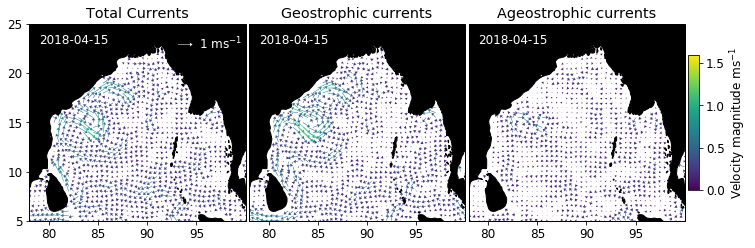

In [24]:
plot_geo_ageo_total_currents(time1="2018-04-15", save=True, savename="./plots/currents/2018_04_15.png")

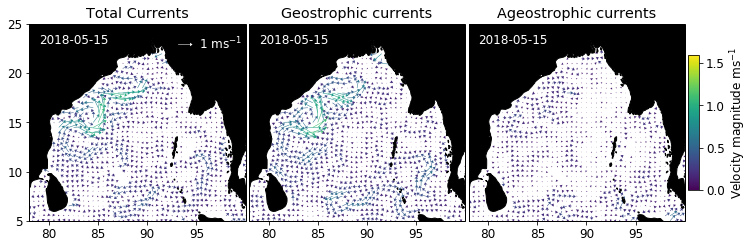

In [25]:
plot_geo_ageo_total_currents(time1="2018-05-15", save=True, savename="./plots/currents/2018_05_15.png")

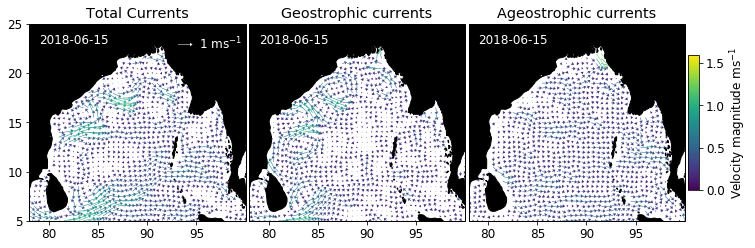

In [26]:
plot_geo_ageo_total_currents(time1="2018-06-15", save=True, savename="./plots/currents/2018_06_15.png")

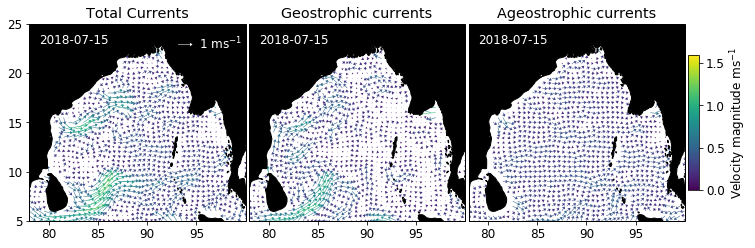

In [27]:
plot_geo_ageo_total_currents(time1="2018-07-15", save=True, savename="./plots/currents/2018_07_15.png")

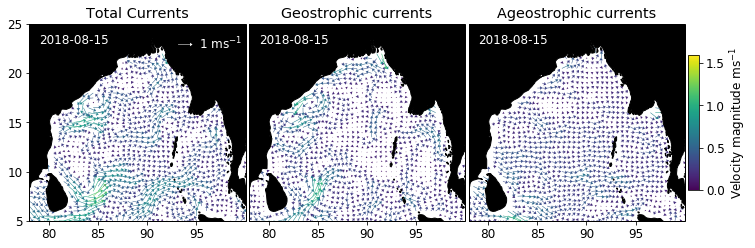

In [28]:
plot_geo_ageo_total_currents(time1="2018-08-15", save=True, savename="./plots/currents/2018_08_15.png")

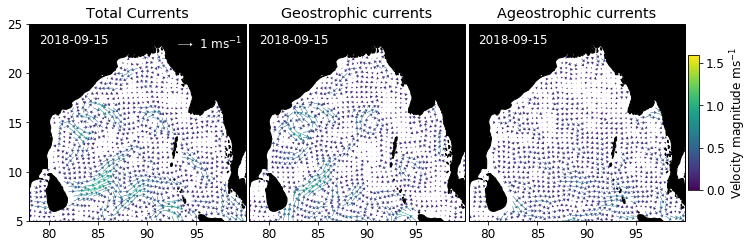

In [29]:
plot_geo_ageo_total_currents(time1="2018-09-15", save=True, savename="./plots/currents/2018_09_15.png")

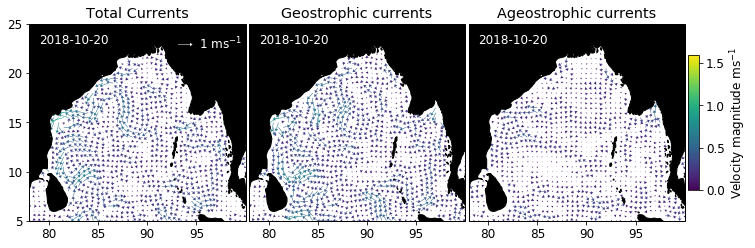

In [30]:
plot_geo_ageo_total_currents(time1="2018-10-20", save=True, savename="./plots/currents/2018_10_20.png")